<a href="https://colab.research.google.com/github/hojoongYi/Machine_Intelligence_I/blob/main/exercise_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# preparing datasets, transformations, DataLoaders

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=False)

mini_batch = 100
train_loader = DataLoader(train_dataset, batch_size=mini_batch, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_dataset.__len__(), shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.45MB/s]


In [ ]:
# train & test loop

def test_loop(model, data_loader, device):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in data_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, pred = torch.max(outputs, 1)
      correct += (pred == labels).sum().item()
      total += labels.size(0)
  model.train()

  return correct / total

def train_loop(model, train_loader, test_loader, optimizer, loss_fn, epochs, device):
  model.to(device)
  model.train()

  train_accs = []
  test_accs = []

  for epoch in range(1, epochs+1):
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = loss_fn(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    if epoch % 1 == 0:
      percent = (epoch / epochs) * 100
      train_acc = test_loop(model, train_loader, device)
      test_acc = test_loop(model, test_loader, device)
      train_accs.append(train_acc)
      test_accs.append(test_acc)
      print(f"Epoch {epoch}/{epochs} ({percent:.1f}%): Loss: {loss.item():.3f} Train Acc = {train_acc:.4f}, Test acc = {test_acc:.4f}")

  return train_accs, test_accs

In [ ]:
# model 1: linear model - MNIST is 1x28x28

class LinearModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(28*28, 10) # 28*28 = 784
    nn.init.zeros_(self.linear.weight)
    nn.init.zeros_(self.linear.bias)

  def forward(self, x):
    x = x.view(-1, 784) # flatten the input
    return self.linear(x)

# train the model with 100 epochs (200 epochs take too much time)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = LinearModel()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model1.parameters(), lr=0.5)

train_acc_1, test_acc_1 = train_loop(model1, train_loader, test_loader, optimizer, loss_fn, epochs=100, device=device)

Epoch 1/100 (1.0%): Loss: 0.224 Train Acc = 0.9141, Test acc = 0.9142
Epoch 2/100 (2.0%): Loss: 0.231 Train Acc = 0.9177, Test acc = 0.9179
Epoch 3/100 (3.0%): Loss: 0.171 Train Acc = 0.9217, Test acc = 0.9214
Epoch 4/100 (4.0%): Loss: 0.299 Train Acc = 0.9261, Test acc = 0.9214
Epoch 5/100 (5.0%): Loss: 0.354 Train Acc = 0.9203, Test acc = 0.9199
Epoch 6/100 (6.0%): Loss: 0.273 Train Acc = 0.9234, Test acc = 0.9214
Epoch 7/100 (7.0%): Loss: 0.142 Train Acc = 0.9278, Test acc = 0.9240
Epoch 8/100 (8.0%): Loss: 0.387 Train Acc = 0.9288, Test acc = 0.9238
Epoch 9/100 (9.0%): Loss: 0.332 Train Acc = 0.9292, Test acc = 0.9245
Epoch 10/100 (10.0%): Loss: 0.455 Train Acc = 0.9283, Test acc = 0.9223
Epoch 11/100 (11.0%): Loss: 0.274 Train Acc = 0.9297, Test acc = 0.9249
Epoch 12/100 (12.0%): Loss: 0.156 Train Acc = 0.9281, Test acc = 0.9227
Epoch 13/100 (13.0%): Loss: 0.232 Train Acc = 0.9295, Test acc = 0.9232
Epoch 14/100 (14.0%): Loss: 0.127 Train Acc = 0.9313, Test acc = 0.9236
Epoch 15/1

In [ ]:
# model 2: MLP

class MLP(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, device):
    super(MLP, self).__init__()
    self.model = nn.Sequential(
        # 3 hidden layers
        nn.Flatten(),
        nn.Linear(input_dim, hidden_dim),
        # activation function: ReLU for each hidden neurons
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, output_dim),
    )

    self.model.apply(self.init_weights)
    self.model.to(device)

  def init_weights(self, m):
    if isinstance(m, nn.Linear):
        mean = 0.0
        std = 0.05
        with torch.no_grad():
          weight = torch.normal(mean, std, size=m.weight.shape)
          # recalculate weight values if they exceed 2 * std
          bad_val = torch.abs(weight) > 2 * std
          while bad_val.any():
            resample = torch.normal(mean, std, size=(bad_val.sum(),), device=weight.device)
            weight[bad_val] = resample
            bad_val = torch.abs(weight) > 2 * std
          m.weight.copy_(weight)

          m.bias.fill_(0.1)

  def forward(self, x):
    return self.model(x)

# train the model with 100 epochs (200 epochs take too much time)

input_dim = 784
hidden_dim = 512 # 1500 neurons seem too many
output_dim = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = MLP(input_dim, hidden_dim, output_dim, device)
loss_fn = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-04)
train_acc_2, test_acc_2 = train_loop(model2, train_loader, test_loader, optimizer2, loss_fn, epochs=100, device=device)

Epoch 1/200 (0.5%): Loss: 0.062 Train Acc = 0.9772, Test acc = 0.9706
Epoch 2/200 (1.0%): Loss: 0.054 Train Acc = 0.9779, Test acc = 0.9676
Epoch 3/200 (1.5%): Loss: 0.019 Train Acc = 0.9872, Test acc = 0.9753
Epoch 4/200 (2.0%): Loss: 0.090 Train Acc = 0.9800, Test acc = 0.9665
Epoch 5/200 (2.5%): Loss: 0.074 Train Acc = 0.9895, Test acc = 0.9789
Epoch 6/200 (3.0%): Loss: 0.001 Train Acc = 0.9912, Test acc = 0.9773
Epoch 7/200 (3.5%): Loss: 0.044 Train Acc = 0.9913, Test acc = 0.9780
Epoch 8/200 (4.0%): Loss: 0.054 Train Acc = 0.9913, Test acc = 0.9780
Epoch 9/200 (4.5%): Loss: 0.008 Train Acc = 0.9919, Test acc = 0.9787
Epoch 10/200 (5.0%): Loss: 0.070 Train Acc = 0.9911, Test acc = 0.9768
Epoch 11/200 (5.5%): Loss: 0.018 Train Acc = 0.9953, Test acc = 0.9832
Epoch 12/200 (6.0%): Loss: 0.016 Train Acc = 0.9952, Test acc = 0.9815
Epoch 13/200 (6.5%): Loss: 0.068 Train Acc = 0.9940, Test acc = 0.9787
Epoch 14/200 (7.0%): Loss: 0.023 Train Acc = 0.9952, Test acc = 0.9813
Epoch 15/200 (7

In [ ]:
# model 3: MLP with dropout regularization

class MLP_dropout(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, device):
    super().__init__()
    self.model = nn.Sequential(
        # 3 hidden layers
        nn.Flatten(),
        nn.Linear(input_dim, hidden_dim),
        # activation function: ReLU for each hidden neurons
        nn.ReLU(),
        # dropout rate of 0.5 - after the activation function
        nn.Dropout(p=0.5),

        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Dropout(p=0.5),

        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Dropout(p=0.5),

        nn.Linear(hidden_dim, output_dim),
    )

    self.model.apply(self.init_weights)
    self.model.to(device)

  def init_weights(self, m):
    if isinstance(m, nn.Linear):
        mean = 0.0
        std = 0.05
        with torch.no_grad():
          weight = torch.normal(mean, std, size=m.weight.shape)
          # recalculate weight values if they exceed 2 * std
          bad_val = torch.abs(weight) > 2 * std
          while bad_val.any():
            resample = torch.normal(mean, std, size=(bad_val.sum(),), device=weight.device)
            weight[bad_val] = resample
            bad_val = torch.abs(weight) > 2 * std
          m.weight.copy_(weight)

          m.bias.fill_(0.1)

  def forward(self, x):
    return self.model(x)

# train the model with 100 epochs (200 epochs take too much time)

input_dim = 784
hidden_dim = 512 # 1500 neurons seem too many
output_dim = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3 = MLP_dropout(input_dim, hidden_dim, output_dim, device)
loss_fn = nn.CrossEntropyLoss()
optimizer3 = optim.Adam(model3.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-04)
train_acc_3, test_acc_3 = train_loop(model3, train_loader, test_loader, optimizer3, loss_fn, epochs=100, device=device)

Epoch 1/100 (1.0%): Loss: 0.184 Train Acc = 0.9638, Test acc = 0.9598
Epoch 2/100 (2.0%): Loss: 0.112 Train Acc = 0.9729, Test acc = 0.9679
Epoch 3/100 (3.0%): Loss: 0.071 Train Acc = 0.9787, Test acc = 0.9723
Epoch 4/100 (4.0%): Loss: 0.098 Train Acc = 0.9827, Test acc = 0.9755
Epoch 5/100 (5.0%): Loss: 0.148 Train Acc = 0.9848, Test acc = 0.9770
Epoch 6/100 (6.0%): Loss: 0.105 Train Acc = 0.9864, Test acc = 0.9782
Epoch 7/100 (7.0%): Loss: 0.170 Train Acc = 0.9866, Test acc = 0.9793
Epoch 8/100 (8.0%): Loss: 0.113 Train Acc = 0.9850, Test acc = 0.9766
Epoch 9/100 (9.0%): Loss: 0.063 Train Acc = 0.9897, Test acc = 0.9804
Epoch 10/100 (10.0%): Loss: 0.151 Train Acc = 0.9873, Test acc = 0.9790
Epoch 11/100 (11.0%): Loss: 0.094 Train Acc = 0.9901, Test acc = 0.9812
Epoch 12/100 (12.0%): Loss: 0.081 Train Acc = 0.9920, Test acc = 0.9797
Epoch 13/100 (13.0%): Loss: 0.033 Train Acc = 0.9914, Test acc = 0.9790
Epoch 14/100 (14.0%): Loss: 0.134 Train Acc = 0.9923, Test acc = 0.9799
Epoch 15/1

In [16]:
# model 4: CNN

class CNN(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, device):
    super(CNN, self).__init__()

    self.model = nn.Sequential(
        # nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2, bias=True), # P = K // 2
        nn.ReLU(),
        nn.MaxPool2d(2, stride=2),
        nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2, bias=True),
        nn.ReLU(),
        nn.MaxPool2d(2, stride=2),

        # input: 28*28
        # after 1st pooling: 28*28 -> 14*14
        # after 2nd pooling: 14*14 -> 7*7
        nn.Flatten(),
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, output_dim)
    )

    self.model.apply(self.init_weights)
    self.model.to(device)

  def init_weights(self, m):
    if isinstance(m, nn.Linear):
      mean = 0.0
      std = 0.05
      with torch.no_grad():
        weight = torch.normal(mean, std, size=m.weight.shape)
        bad_val = torch.abs(weight) > 2 * std
        while bad_val.any():
          resample = torch.normal(mean, std, size=(bad_val.sum(),), device=weight.device)
          weight[bad_val] = resample
          bad_val = torch.abs(weight) > 2 * std
        m.weight.copy_(weight)

        m.bias.fill_(0.1)

  def forward(self, x):
    return self.model(x)

# train the model with 100 epochs (200 epochs take too much time)

input_dim = 64*7*7
hidden_dim = 512 # 1500 neurons seem too many
output_dim = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(input_dim, hidden_dim, output_dim, device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-04)
train_loop(model, train_loader, test_loader, optimizer, loss_fn, epochs=100, device=device)

KeyboardInterrupt: 

In [ ]:
# model 4: CNN (following solution given)

class CNN(nn.Module):
  def __init__(self):
    super().__init__()

    # channels/filter of first, second convolutional layer
    self.out_channels1 = 32
    self.out_channels2 = 64

    self.conv1 = nn.Conv2d(1, self.out_channels1, kernel_size=5, stride=1, padding=2) # P = K // 2
    self.conv2 = nn.Conv2d(self.out_channels1, self.out_channels2, kernel_size=5, stride=1, padding=2)

    # input: 28*28
    # after 1st pooling: 28*28 -> 14*14
    # after 2nd pooling: 14*14 -> 7*7
    # output_dim = 10 (onehot from digits 0 to 9)

    self.fc1 = nn.Linear(7*7*self.out_channels2, 10)


  def init_weights(self):
    init.normal(self.conv1.weight, mean=0, std=0.1)
    init.normal(self.conv2.weight, mean=0, std=0.1)

    init.constant(self.conv1.bias, 0.1)
    init.constant(self.conv2.bias, 0.1)

  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), 2)
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)

    x = x.view(x.size(0), -1)
    x = self.fc1(x)

    return x

# train the model with 100 epochs (200 epochs take too much time)

model4 = CNN()
optimizer4 = optim.Adam(model4.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-04)
loss_fn = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_acc_4, test_acc_4 = train_loop(model4, train_loader, test_loader, optimizer4, loss_fn, epochs=100, device=device)

Epoch 1/100 (1.0%): Loss: 0.078 Train Acc = 0.9828, Test acc = 0.9827
Epoch 2/100 (2.0%): Loss: 0.033 Train Acc = 0.9887, Test acc = 0.9885
Epoch 3/100 (3.0%): Loss: 0.007 Train Acc = 0.9933, Test acc = 0.9920
Epoch 4/100 (4.0%): Loss: 0.054 Train Acc = 0.9929, Test acc = 0.9910
Epoch 5/100 (5.0%): Loss: 0.027 Train Acc = 0.9942, Test acc = 0.9918
Epoch 6/100 (6.0%): Loss: 0.085 Train Acc = 0.9938, Test acc = 0.9898
Epoch 7/100 (7.0%): Loss: 0.031 Train Acc = 0.9953, Test acc = 0.9909
Epoch 8/100 (8.0%): Loss: 0.104 Train Acc = 0.9973, Test acc = 0.9927
Epoch 9/100 (9.0%): Loss: 0.013 Train Acc = 0.9966, Test acc = 0.9900
Epoch 10/100 (10.0%): Loss: 0.002 Train Acc = 0.9963, Test acc = 0.9893
Epoch 11/100 (11.0%): Loss: 0.031 Train Acc = 0.9964, Test acc = 0.9908
Epoch 12/100 (12.0%): Loss: 0.055 Train Acc = 0.9977, Test acc = 0.9916
Epoch 13/100 (13.0%): Loss: 0.032 Train Acc = 0.9973, Test acc = 0.9908
Epoch 14/100 (14.0%): Loss: 0.038 Train Acc = 0.9973, Test acc = 0.9920
Epoch 15/1

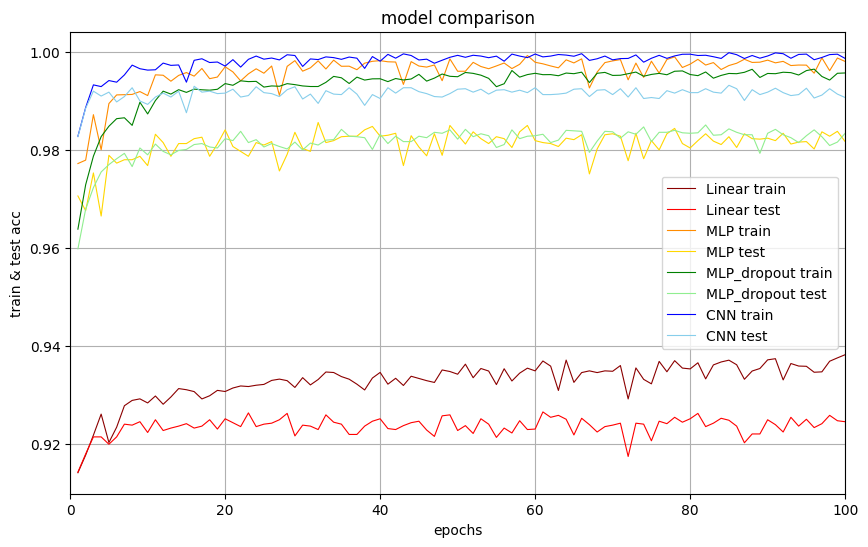

In [ ]:
epochs100 = range(1, len(train_acc_1)+1)
epochs200 = range(1, len(train_acc_2)+1)

plt.figure(figsize=(10, 6))

plt.plot(epochs100, train_acc_1, label='Linear train', color='darkred', linewidth=0.8)
plt.plot(epochs100, test_acc_1, label='Linear test', color='red', linewidth=0.8)

plt.plot(epochs200, train_acc_2, label='MLP train', color='darkorange', linewidth=0.8)
plt.plot(epochs200, test_acc_2, label='MLP test', color='gold', linewidth=0.8)

plt.plot(epochs100, train_acc_3, label='MLP_dropout train', color='green', linewidth=0.8)
plt.plot(epochs100, test_acc_3, label='MLP_dropout test', color='lightgreen', linewidth=0.8)

plt.plot(epochs100, train_acc_4, label='CNN train', color='blue', linewidth=0.8)
plt.plot(epochs100, test_acc_4, label='CNN test', color='skyblue', linewidth=0.8)

plt.xlim(0, 100)
#plt.ylim(0, 1.0)
plt.xlabel('epochs')
plt.ylabel('train & test acc')
plt.title('model comparison')
plt.legend()
plt.grid(True)
plt.show()